# FGC Experiments

### Importing Libraries

In [3]:
!pip install deeprobust

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis



import random
from deeprobust.graph.data import Dataset

No module named 'torch_sparse'


C:\Users\USER\anaconda3\lib\site-packages\deeprobust\graph\data\__init__.py:9: UserWarning: Please install pytorch geometric if you would like to use the datasets from pytorch geometric. See details in https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
  warnings.warn("Please install pytorch geometric if you " +


# Real Datasets Import

In [5]:
dataset_name = 'cora' #other datatsets : 'citeseer' , 'polblogs' , 'acm'

In [6]:
ori_nodes = 2708 #original number of nodes.
## citeseer : 3312
## cora     : 2708
## polblogs : 1490
## acm      : 3025

In [7]:
data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

A = np.array(adj.todense())
X=np.array(features.todense())
np.save("A.npy", A)
print(A)
#np.save("X.npy", X)
print(X)
import numpy as np
b=np.ones(ori_nodes)

z=A@b
D=np.diag(z)
L=D-A
print(L)

Loading polblogs dataset...
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[26. -1.  0. ...  0.  0.  0.]
 [-1. 45.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1. 18.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]]


##### RUN BELOW CELL ONLY FOR POLBLOGS AS FEATURES NEED TO CREATED FOR POLBLOGS DATASET

In [9]:
n = 5000
X = np.random.multivariate_normal(np.zeros(1490), np.linalg.pinv(L), n).T
X.shape

(1490, 5000)

#### Minnesota, Airfoil and Bunny datasets have been taken from pygsp library 

In [ ]:
import pygsp as gsp
from pygsp import graphs
G=graphs.Airfoil()
print(G.N)
L=G.L.toarray()
print(L)

# Creating Synthetic Datasets.

In [ ]:
# Some Input parameters.
p=1000 # number of nodes
param = 0.1  
#graph = erdos_renyi_graph(p, param, directed = False)
#graph = nx.barabasi_albert_graph(n=p,m=20)
#graph = watts_strogatz_graph(p,20,param,seed=12)
graph=nx.random_geometric_graph(p,param)


# DISPLAY GENERATED GRAPH.
print(graph.edges)
print(graph.nodes)
# PLOTTING GENERATED GRAPH.
nx.draw(graph, with_labels = True)
plt.title("Laplacian")
plt.show()
# CREATING EDGE WEIGHTS.
W = np.zeros((p, p))
for (x, y) in graph.edges:
    W[x][y] = np.random.randint(1,10)       #weight of edge between x and y
W_t = W + W.T
# CALCULATING LAPLACIAN MATRIX OF GENERATED GRAPH.
L = np.diag(W_t@np.ones((W_t.shape[0]))) - W_t
print(L)
print(L.shape)

In [ ]:
# Creating Fetures for any synthetic graph:
n = 5000 # number of features of each node.
X = np.random.multivariate_normal(np.zeros(p), np.linalg.pinv(L), n).T
X.shape
print(X)

# FGC Algorithm

In [10]:
class solver_v2:

  def __init__(self, X, k, lambda_param, beta_param, alpha_param, gamma_param):
    self.X = X
    self.p = X.shape[0]
    self.k = k
    self.n = X.shape[1]
    
    n = self.n
    k = self.k
    p = self.p
    
    self.thresh = 1e-10 # The 0-level

    # Basic initialization (Completely random)
    self.X_tilde = np.random.normal(0, 1, (k, n))
    
    self.C = np.random.normal(0,1,(p,k))
    self.C[self.C < self.thresh] = self.thresh
    
    self.w = np.random.normal(10, 1, (k*(k-1))//2)
    self.w[self.w < self.thresh] = self.thresh


    # Model Hyperparameters
    self.beta_param = beta_param
    self.alpha_param = alpha_param
    self.lambda_param = lambda_param
    self.gamma_param = gamma_param
    self.iters = 0
    self.lr0 = 1e-5

  def getLR(self):
    a = 0.99
    return self.lr0

  def calc_f(self):
    
    #w = self.w
    X_tilde = self.X_tilde
    beta_param = self.beta_param
    #Lw = self.L_operator(w)
    #L = np.load('L (5).npy')
    fw = 0

    fw += np.trace(X_tilde.T@self.C.T@L@self.C @X_tilde)
    # Added the tr(X.T L X) term
   # fw += ((beta_param*(np.linalg.norm(Lw)**2))/2)
    # Added the Frobbenius norm term
    J = np.outer(np.ones(self.k), np.ones(self.k))/self.k
    fw -= self.gamma_param*np.linalg.slogdet(self.C.T@L@self.C + J)[1]
    # Added the log_det term
    fw += (self.alpha_param/2)*(np.linalg.norm(np.subtract(self.X, np.dot(self.C, self.X_tilde))))**2
    # Added l2 norm || X - C*X_tilde ||
    fw += (self.lambda_param)/2*((np.linalg.norm(np.dot(self.C, np.ones((self.k, 1)))))**2)
    # Added L_1,2 norm || C ||
    return fw

  def update_X_tilde(self):
    #L = np.load('L (5).npy')
    L_tilde = self.C.T@L@self.C
    A = 2*L_tilde/(self.alpha_param)
    A = A + np.dot(self.C.T, self.C)
    b = np.dot(self.C.T, self.X)
    # Update 1
    self.X_tilde = np.linalg.pinv(A)@b

    # Update 2
    # lr = self.getLR()
    # self.X_tilde = self.X_tilde - lr*self.alpha_param*(A@self.X_tilde - b)

    # #new update:
    for i in range(len(self.X_tilde)):
      self.X_tilde[i] = (self.X_tilde[i]/(np.linalg.norm(self.X_tilde[i])))


    return None

  def grad_C(self):
    #L = np.load('L (5).npy')
    J = np.outer(np.ones(k), np.ones(k))/k
    v=np.linalg.pinv(self.C.T@L@self.C + J)
    gradC = np.zeros(self.C.shape)
    gradC += self.alpha_param*((self.C@self.X_tilde - self.X)@self.X_tilde.T)
    gradC += (self.lambda_param) * (np.abs(self.C) @ (np.ones((self.k, self.k))))
    gradC += -2*(self.gamma_param)*L@self.C@v
    gradC += 2*L@self.C@self.X_tilde@self.X_tilde.T
    
    return gradC

  def update_C(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    C = self.C
    C = C - lr*self.grad_C()
    C[C<self.thresh] = self.thresh
    self.C = C
    C = self.C.copy()

    for i in range(len(C)):
      C[i] = C[i]/np.linalg.norm(C[i],1)

    self.C = C.copy()
    return None

  
  def fit(self, max_iters):
    ls = []
    MAX_ITER_INT = 100
    for i in tqdm(range(max_iters)):
      #for _ in range(MAX_ITER_INT):
        #self.update_w()
      for _ in range(MAX_ITER_INT):
        self.update_C(1/self.k)
      # for _ in range(MAX_ITER_INT):
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      #print(self.C@self.C.T)
      #print()

    return (self.C, self.X_tilde, ls )

  def New_fit(self):
    ls=[]
    MAX_ITER_INT = 100
    while(True):
      C_prev=self.C
      self.update_C(1/self.k)
      self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      if(np.linalg.norm(self.C-C_prev)<0.1): # we have set the threshold for stopping criteria as 0.1.
          return (self.C, self.X_tilde, ls )      
    return (self.C, self.X_tilde, ls )    

  def set_experiment(self, X, X_t):
    self.X = X
    self.X_tilde = X_t

FGC has only 3 hyperparameters lambda, alpha and gamma. beta is not any hyperparameter (it is of no use), you can put it equal to any number

In [ ]:
# Below shown for Cora.
k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
overall_loss = []
iterations = 10 # Number of iterations our objective function will run.
#print("Shape of the data matrix (p x n): ", X_now.shape)

# Hyperparameters: lambda, beta, alpha, gamma
obj = solver_v2(X, k, 500, 0, 500, X.shape[1]/2) 
C_0, X_t_0, loss_ls = obj.fit(iterations)
overall_loss.extend(loss_ls)



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Note: If you want to work with mentioned stopping criteria from the paper, then you can use obj.New_fit() in place of obj.fit(). 

### In below cell, we are computing REE and DE. 

 eigen_error 
(0.09344485166350994+0j)


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


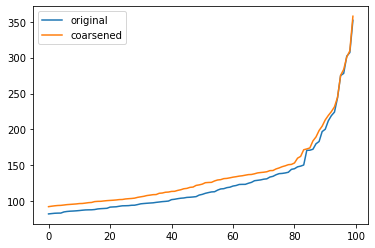

30670.12849126975
6113760.193609843
1219.5608020877253


In [16]:
eigen_values,eigenvectors=np.linalg.eig(L)

s=np.sort(eigen_values)

eigen_value,eigenvector=np.linalg.eig(C_0.T@L@C_0)

z=np.sort(eigen_value) 


s_new=s[-100:]
z_new=z[-100:]

temp=0
for j in range(len(s_new)):
  temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
eigenerror=temp/len(s_new)
print(" eigen_error ")
print(eigenerror)

plt.plot(s_new, label="original")
plt.plot(z_new, label="coarsened")
plt.legend()
plt.show()

print(np.trace(X_t_0.T@C_0.T@L@C_0@X_t_0))
print(np.trace(X.T@L@X))

### Below, we are plotting heat map of C^TC.

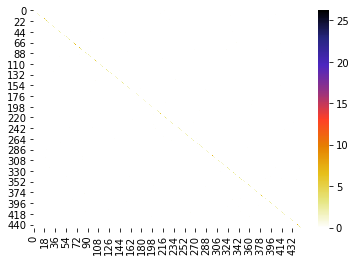

In [17]:
import seaborn as sns
import matplotlib.pylab as plt
# sns.heatmap(C_0.T@C_0)
a = sns.heatmap(C_0.T@C_0,cmap='CMRmap_r')
#plt.title("Cora", x=0.5, y=0.9,weight="bold")
# a.figure.savefig("polblogs_heatmap_03.eps",dpi=1500)

### Plotting loss for r = 0.3,0.5,0.7.

In [ ]:
# Ans is a list of 3 arrays which corresponds to loss values for FGC at r=0.3, 0.5 and 0.7. 
l3=Ans[0] # loss values for FGC at r=0.3
l5=Ans[1] # loss values for FGC at r=0.5
l7=Ans[2] # loss values for FGC at r=0.7
plt.plot(np.log(l3),':',label='Coarsening ratio: 0.3')
plt.plot(np.log(l5),'-.',label='Coarsening ratio: 0.5')
plt.plot(np.log(l7),'--',label='Coarsening ratio: 0.7')
plt.legend(loc="upper right")
plt.xlabel('Number of iterations')
plt.ylabel('log(Loss)')
plt.savefig('final_citeseer_losscurve.eps', dpi=1500)

### plotting top-100 eigen values curves for r=0.3,0.5,0.7.

In [ ]:
#X = np.load('X (5).npy')
#L = np.load('L (5).npy')
eigen_values,eigenvectors=np.linalg.eig(L)
#sort=eigen_values.argsort()[::-1]
#eigen_values = eigen_values[sort] 
#print(eigen_values)
s=np.sort(eigen_values)
# print(s)
#print(eigen_values.dtype)
eigen_value,eigenvector=np.linalg.eig(C_0.T@L@C_0)
#sorted=eigen_value.argsort()[::-1] 
#eigen_value = eigen_value[sorted]
z=np.sort(eigen_value) 
#print(z)
s_new=s[-100:]
z_new=z[-100:]
temp=0
for j in range(len(s_new)):
  temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
eigenerror1=temp/len(s_new)
print(" eigen_error 1")
print(eigenerror1)
#X = np.load('X (5).npy')
#L = np.load('L (5).npy')
#eigen_values,eigenvectors=np.linalg.eig(L)
#sort=eigen_values.argsort()[::-1]
#eigen_values = eigen_values[sort] 
#print(eigen_values)
#s=np.sort(eigen_values)
#print(s)
#print(eigen_values.dtype)


#2
eigen_value2,eigenvector2=np.linalg.eig(C1@L@C1.T)
#sorted=eigen_value.argsort()[::-1] 
#eigen_value = eigen_value[sorted]
zc2=np.sort(eigen_value2) 
#print(z)
#s_new=s[1:100]
zc_new2=zc2[-100:]
temp2=0
for j in range(len(s_new)):
  temp2=temp2+(abs(zc_new2[j]-s_new[j])/s_new[j])
eigenerror2=temp2/len(s_new)


#3
eigen_value3,eigenvector3=np.linalg.eig(C2@L@C2.T)
#sorted=eigen_value.argsort()[::-1] 
#eigen_value = eigen_value[sorted]
zc3=np.sort(eigen_value3) 
#print(z)
#s_new=s[1:100]
zc_new3=zc3[-100:]
temp3=0
for j in range(len(s_new)):
  temp3=temp3+(abs(zc_new3[j]-s_new[j])/s_new[j])
eigenerror3=temp3/len(s_new)



print(" eigen_error ")
print(eigenerror1)
print(eigenerror2)
print(eigenerror3)
plt.plot(s_new,label="Original")
plt.plot(z_new,':', label="FGC")
plt.plot(zc_new2,'-.', label="LVE")
plt.plot(zc_new3,'--', label="LVN")
plt.title("Citeseer", x=0.5, y=0.9,weight="bold")
# plt.ylabel('Relative eigen-value error')
# plt.xlabel('Nth eigenvalue')
plt.legend()
plt.legend()
plt.savefig('citeseer_eigenvalues.eps', dpi=1500)
plt.show()

# epsilon plot

In [ ]:
# For Cora.
Ans=[] # It will store loss for different coarsening ratios.
#n=5000
k=[270,541,812,1083,1354,1624] # [0.1*ori_nodes,0.2*ori_nodes,0.3*ori_nodes,0.4*ori_nodes,0.5*ori_nodes,0.6*ori_nodes]
for j in k:
    #X = np.random.multivariate_normal(np.zeros(1490), np.linalg.pinv(L), n).T
    #k = 300
    overall_loss = []
    iterations = 10
    #print("Shape of the data matrix (p x n): ", X_now.shape)

    # Hyperparameters: lambda, beta, alpha, gamma
    obj = solver_v2(X, j, 500, 20, 500, X.shape[1]/2) 
    C_0, X_t_0, loss_ls = obj.fit(iterations)
    overall_loss.extend(loss_ls)
    AA=(X-(C_0@X_t_0))
    Ans=Ans+[np.trace((AA.T)@L@AA)/np.trace((X.T)@L@X)]

In [ ]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6],Ans,'o-',label='Cora',color='b')
plt.legend(loc="lower left",fontsize=8)
plt.xlabel('Coarsening Ratio')
plt.ylabel('Epsilon')
plt.savefig('Epsilon_Cora.eps', dpi=1200)

## Hyperbolic Error using feature matrix X

In [ ]:
def HE(u,v):
    return np.arccosh(1+((pow(np.linalg.norm((u-v)@X),2)*pow(np.linalg.norm(X),2))/(2*np.trace(X.T@u@X)*np.trace(X.T@v@X))))

In [ ]:
P=np.linalg.pinv(C_0)
L_lift=P.T@C_0.T@L@C_0@P
HE(L_lift,L)

## Reconstructional Error 

In [ ]:
#For cora
p=2708 # put p = no. of nodes in the graph network. 
P=np.linalg.pinv(C_0)
L_lift=P.T@C_0.T@L@C_0@P
LL=(L-L_lift)
np.log(pow(np.linalg.norm(LL),2)/p)

### Zachary's Karate Club dataset

In [ ]:
import torch
from scipy.sparse import csr_matrix
from collections import Counter
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch
from scipy.sparse import csr_matrix
from collections import Counter
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_dense_adj
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = KarateClub()
n_classes = len(set(np.array(dataset[0].y)))
data = dataset[0].to(device)
A=to_dense_adj(data.edge_index)[0]
X=data.x  
A=A.numpy()
print((A!=0).sum())
print(X)
import numpy as np
b=np.ones(34)
z=A@b
D=np.diag(z)
L=D-A
print(L)


# Comment these two lines to have graph data with 4 classes.
data.y[data.y==3]=1
data.y[data.y==2]=0




y=data.y.numpy()
print(y)

# Creating features for zachary's karate club dataset.

X=np.random.multivariate_normal(np.zeros(34), np.linalg.pinv(L), 600).T;

In [ ]:
# After getting C_0 (loading matrix), below code will classify nodes into 2 classes using C_0.  
# Below y is a vector of actual labels of nodes in original graph G.
import numpy
def f(r):
    m=max(r)
    if(r[0]==m):
        return 0
    elif(r[1]==m):
        return 1
print(numpy.apply_along_axis(f, 1, C_0)) # Labels given by FGC.
print(y)# Original labels.
print(max((numpy.apply_along_axis(f, 1, C_0)==y).sum(),(numpy.apply_along_axis(f, 1, C_0)!=y).sum())) # Number of correctly classified nodes.   

#### Effects of Hyperparameters 

Below, code for change of gamma is written. For change in alpha/lambda, place iterator 'i' inplace of that parameter. Hyperparameters for best case (gamma, alpha, lambda)=(600,500,1000).

In [ ]:
# Below shown for BA.
C=[]
Xc=[]
overall_loss = []
for i in [100,200,300,400,500,600,700,800,900,1000,2000,5000,10000,50000]:
    k = 700 
    iterations = 10 
    obj = solver_v2(X, k, i,0, 500, 1000) 
    C_0, X_t_0, loss_ls = obj.fit(iterations)
    overall_loss.extend(loss_ls)
    C=C+[C_0]
    Xc=Xc+[X_t_0]

In [ ]:
I=[100,200,300,400,500,600,700,800,900,1000,2000,5000,10000,50000]
i=0
C_0=C_gamma[13]
X_t_0=Xc_gamma[13]
while(i<14):
    eigen_values,eigenvectors=np.linalg.eig(L)
    s=np.sort(eigen_values)
    s_new=s[-105:-5]
    plt.plot(s_new, label="Original")
    print(I[i])
    eigen_value,eigenvector=np.linalg.eig(C_0.T@L@C_0)
    z=np.sort(eigen_value) 
    z_new=z[-105:-5]
    temp=0
    for j in range(len(s_new)):
      temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
    eigenerror=temp/len(s_new)
    print(" eigen_error ")
    print(eigenerror)
    print(np.trace(X_t_0.T@C_0.T@L@C_0@X_t_0))
    plt.plot(z_new, label="Coarsened")
    i=i+1
    plt.legend()
    plt.show()


### Graclus and Spectral Clustering

In [ ]:
# We used Graclus from torch_geometric library.
from torch_geometric.nn import graclus
from scipy import sparse
Wc=sparse.csr_matrix(A)
Wc = Wc.tocoo()
row = torch.from_numpy(Wc.row).to(torch.long)
col = torch.from_numpy(Wc.col).to(torch.long)
edge_index_coarsen1 = torch.stack([row, col], dim=0)
edge_weight = torch.from_numpy(Wc.data)
a=graclus(edge_index_coarsen1,weight=edge_weight,num_nodes=1490)
b = list(set(a.numpy()))
print(b)

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import KMeans
# A is weight matrix and L is laplacian matrix of the original graph.
dMat = np.diag(np.sum(A, axis=0))
dMat_inv_sqrt = fractional_matrix_power(dMat, -0.5)
laplacian_ncut = np.identity(dMat.shape[0]) - dMat_inv_sqrt @ A @ dMat_inv_sqrt

def spectral_clustering(laplacian):
    eigVals, eigVecs = np.linalg.eig(laplacian)
    eigVals=eigVals.real 
    eigVecs=eigVecs.real
    # find the second smallest eigenvalue
    eigValInds = list(zip(range(eigVals.size), eigVals.tolist()))
    eigValInds.sort(key=lambda x : x[1])
    #print(eigValInds)
    eigInd = eigValInds[1][0]
    vec = eigVecs[:, eigInd].reshape((-1, 1))
    #print(vec)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(vec)
    assignment = kmeans.predict(vec)
    group1 = np.where(assignment == 0)[0] + 1
    group2 = np.where(assignment == 1)[0] + 1
    print('people in group 1:', group1)
    print('people in group 2:', group2)

In [ ]:
spectral_clustering(L)  

In [ ]:
spectral_clustering(laplacian_ncut)  

You can refer this link for more details for spectral clustering code.
https://www.alanshawn.com/jupyter-nb-show/2019/10/31/spectral-clustering.html

## Adversarial attack for FGC

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis



import random
from deeprobust.graph.data import Dataset
dataset_name ='citeseer' #other datatsets : 'citeseer' , 'polblogs' , 'acm'
ori_nodes =3312 #original number of nodes.
data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

A = np.array(adj.todense())
X=np.array(features.todense())
np.save("A.npy", A)
print((A!=0).sum())
A_copy=A.copy()

attack='random'
rate=0.1 # 0.1->10%, 0.05->5%.
from scipy import sparse
from deeprobust.graph.data import Dataset, PrePtbDataset
if attack == 'random':
    from deeprobust.graph.global_attack import Random
    import random; 
    np.random.seed(10)
    attacker = Random()
    A=sparse.csr_matrix(A)
    A = A.tocoo()
    n_perturbations = int(rate * (A.sum()//2))
    attacker.attack(A, n_perturbations, type='add')
    A = attacker.modified_adj
    A=A.toarray()
    print((A==1).sum())
print(A.shape)


print((A!=0).sum())
#np.save("X.npy", X)
print(X)

# Above is perturbed graph laplacian matrix.
# Below is clean graph laplacian matrix.
import numpy as np
b=np.ones(ori_nodes)

z=A@b
D=np.diag(z)

L=D-A
print(L)

b_copy=np.ones(ori_nodes)

z_copy=A_copy@b_copy
D_copy=np.diag(z_copy)

L_copy=D_copy-A_copy
print(L_copy)


# Here we will obtain laplacian matrices, L_copy and L for clean and attacked graph data.
# We will compare L_copy and Lc obtained from L in REE.

# GC Algorithm

In [ ]:
class solver_v2:

  def __init__(self, k, lambda_param, beta_param, alpha_param, gamma_param):
#     self.X = X
#     self.p = X.shape[0]
    self.k = k
#     self.n = X.shape[1]
    self.p = L.shape[0]
    
    
    
#     n = self.n
    k = self.k
    p = self.p
    
    self.thresh = 1e-10 # The 0-level

    # Basic initialization (Completely random)
#     self.X_tilde = np.random.normal(0, 1, (k, n))
    
    self.C = np.random.normal(0,1,(p,k))
    self.C[self.C < self.thresh] = self.thresh
    
    self.w = np.random.normal(10, 1, (k*(k-1))//2)
    self.w[self.w < self.thresh] = self.thresh


    # Model Hyperparameters
    self.beta_param = beta_param
    self.alpha_param = alpha_param
    self.lambda_param = lambda_param
    self.gamma_param = gamma_param
    self.iters = 0
    self.lr0 = 1e-5

  def getLR(self):
    a = 0.99
    return self.lr0

  def calc_f(self):
    
    #w = self.w
#     X_tilde = self.X_tilde
    beta_param = self.beta_param
    #Lw = self.L_operator(w)
    #L = np.load('L (5).npy')
    fw = 0

#     fw += np.trace(X_tilde.T@self.C.T@L@self.C @X_tilde)
    # Added the tr(X.T L X) term
   # fw += ((beta_param*(np.linalg.norm(Lw)**2))/2)
    # Added the Frobbenius norm term
    J = np.outer(np.ones(self.k), np.ones(self.k))/self.k
    fw -= self.gamma_param*np.linalg.slogdet(self.C.T@L@self.C + J)[1]
    # Added the log_det term
#     fw += (self.alpha_param/2)*(np.linalg.norm(np.subtract(self.X, np.dot(self.C, self.X_tilde))))**2
    # Added l2 norm || X - C*X_tilde ||
    fw += (self.lambda_param)/2*((np.linalg.norm(np.dot(self.C, np.ones((self.k, 1)))))**2)
    # Added L_1,2 norm || C ||
    return fw

#   def update_X_tilde(self):
#     #L = np.load('L (5).npy')
#     L_tilde = self.C.T@L@self.C
#     A = 2*L_tilde/(self.alpha_param)
#     A = A + np.dot(self.C.T, self.C)
#     b = np.dot(self.C.T, self.X)
#     # Update 1
#     self.X_tilde = np.linalg.pinv(A)@b

#     # Update 2
#     # lr = self.getLR()
#     # self.X_tilde = self.X_tilde - lr*self.alpha_param*(A@self.X_tilde - b)

#     # #new update:
#     for i in range(len(self.X_tilde)):
#       self.X_tilde[i] = (self.X_tilde[i]/(np.linalg.norm(self.X_tilde[i])))
#     return None

  def grad_C(self):
    #L = np.load('L (5).npy')
    J = np.outer(np.ones(k), np.ones(k))/k
    v=np.linalg.pinv(self.C.T@L@self.C + J)
    gradC = np.zeros(self.C.shape)
#     gradC += self.alpha_param*((self.C@self.X_tilde - self.X)@self.X_tilde.T)
    gradC += (self.lambda_param) * (np.abs(self.C) @ (np.ones((self.k, self.k))))
    gradC += -2*(self.gamma_param)*L@self.C@v
#     gradC += 2*L@self.C@self.X_tilde@self.X_tilde.T
    
    return gradC

  def update_C(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    C = self.C
    C = C - lr*self.grad_C()
    C[C<self.thresh] = self.thresh
    self.C = C
    C = self.C.copy()

    for i in range(len(C)):
      C[i] = C[i]/np.linalg.norm(C[i],1)

    self.C = C.copy()
    return None

  
  def fit(self, max_iters):
    ls = []
    MAX_ITER_INT = 100
    for i in tqdm(range(max_iters)):
      #for _ in range(MAX_ITER_INT):
        #self.update_w()
#       for _ in range(MAX_ITER_INT):
      self.update_C(1/self.k)
      # for _ in range(MAX_ITER_INT):
#       self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      #print(self.C@self.C.T)
      #print()

    return (self.C, ls )

  def New_fit(self):
    ls=[]
    MAX_ITER_INT = 100
    while(True):
      C_prev=self.C
      self.update_C(1/self.k)
      ls.append(self.calc_f())
      self.iters+=1
      if(np.linalg.norm(self.C-C_prev)<0.1):
          return (self.C, ls )      
    return (self.C, ls )    



In [ ]:
# Below shown for Cora.
k = 750 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
overall_loss = []
iterations = 100 # Number of iterations our objective function will run.
#print("Shape of the data matrix (p x n): ", X_now.shape)

# Hyperparameters: lambda, beta, alpha, gamma
# Only lambda and gamma hyperparameters are used. So you can ignore beta and alpha.
obj = solver_v2( k, 300, 0, 0, 250) 
C_0, loss_ls = obj.fit(iterations)
overall_loss.extend(loss_ls)

Hyperbolic error for GC on graph datasets having no features

In [ ]:
E=np.linalg.eig(L)
eigen_values,eigenvectors=E
D={}
# N is the number of nodes in the graph. 
for c in range(N):
    D[eigen_values[c]]=eigenvectors[c]
# print(len(D))
D=dict(sorted(D.items(), key=lambda item: item[0]))
EV=D.values()
ev=D.keys()
ev=np.array(list(ev))
EV=np.array(list(EV))
ev[ev<1e-5]=0
ind=np.argmax(ev==ev[ev!=0][0])
x=EV[ind]
print(x)

In [ ]:
def HE(u,v):
    return np.arccosh(1+((pow(np.linalg.norm((u-v)@x),2)*pow(np.linalg.norm(x),2))/(2*(x.T@u@x)*(x.T@v@x))))
# Above x is eigen vector corresponding to smallest non-zero eigen value. 

## Two stage featured graph coarsening 

In [ ]:
X_tilda=np.linalg.pinv(C_0)@X
Lc=C_0.T@L@C_0
Xc=np.linalg.pinv(np.eye(Lc.shape[0])+Lc)@X_tilda

# FGCR

In [ ]:
class solver_v2:

  def __init__(self, X, k,d, lambda_param, beta_param, alpha_param, gamma_param):
    self.X = X
    self.p = X.shape[0]
    self.n = X.shape[1]
    self.k = k
    self.d = d
    
    p = self.p    
    n = self.n
    k = self.k
    d = self.d

    
    self.thresh = 1e-10 # The 0-level

    # Basic initialization (Completely random)
#     self.X_tilde = np.random.normal(0, 1, (k, n))
    self.W = np.random.normal(0, 1, (k, d))
    self.H = np.random.normal(0, 1, (d, n))
    
    self.C = np.random.normal(0,1,(p,k))
    self.C[self.C < self.thresh] = self.thresh
    
    self.w = np.random.normal(10, 1, (k*(k-1))//2)
    self.w[self.w < self.thresh] = self.thresh
    

    # Model Hyperparameters
    self.beta_param = beta_param
    self.alpha_param = alpha_param
    self.lambda_param = lambda_param
    self.gamma_param = gamma_param
    self.iters = 0
    self.lr0 = 1e-5

  def getLR(self):
    a = 0.99
    return self.lr0

  def calc_f(self):
    
    #w = self.w
#     X_tilde = self.X_tilde
    W=self.W
    H=self.H
    beta_param = self.beta_param
    #Lw = self.L_operator(w)
    #L = np.load('L (5).npy')
    fw = 0

    fw += np.trace(W.T@self.C.T@L@self.C @W)
    # Added the tr(X.T L X) term
   # fw += ((beta_param*(np.linalg.norm(Lw)**2))/2)
    # Added the Frobbenius norm term
    J = np.outer(np.ones(self.k), np.ones(self.k))/self.k
    fw -= self.gamma_param*np.linalg.slogdet(self.C.T@L@self.C + J)[1]
    # Added the log_det term
    fw += (self.alpha_param/2)*(np.linalg.norm(np.subtract(self.X, np.dot(self.C, np.dot(W,H)))))**2
    # Added l2 norm || X - C*X_tilde ||
    fw += (self.lambda_param)/2*((np.linalg.norm(np.dot(self.C, np.ones((self.k, 1)))))**2)
    # Added L_1,2 norm || C ||
    fw += ((beta_param*((np.linalg.norm(W)**2)+(np.linalg.norm(H)**2)))/2)
    # Added Frobbenius norm terms
    return fw

  def update_X_tilde(self):
    #L = np.load('L (5).npy')
    L_tilde = self.C.T@L@self.C
    A = 2*L_tilde/(self.alpha_param)
    A = A + np.dot(self.C.T, self.C)
    b = np.dot(self.C.T, self.X)
    # Update 1
    self.X_tilde = np.linalg.pinv(A)@b

    # Update 2
    # lr = self.getLR()
    # self.X_tilde = self.X_tilde - lr*self.alpha_param*(A@self.X_tilde - b)

    # #new update:
    for i in range(len(self.X_tilde)):
      self.X_tilde[i] = (self.X_tilde[i]/(np.linalg.norm(self.X_tilde[i])))


    return None

  def grad_C(self):
    #L = np.load('L (5).npy')
    J = np.outer(np.ones(k), np.ones(k))/k
    v=np.linalg.pinv(self.C.T@L@self.C + J)
    gradC = np.zeros(self.C.shape)
    gradC += self.alpha_param*((self.C@self.W@self.H - self.X)@self.H.T@self.W.T)
    gradC += (self.lambda_param) * (np.abs(self.C) @ (np.ones((self.k, self.k))))
    gradC += -2*(self.gamma_param)*L@self.C@v
    gradC += 2*L@self.C@self.W@self.W.T
    
    return gradC

  def update_C(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    C = self.C
    C = C - lr*self.grad_C()
    C[C<self.thresh] = self.thresh
    self.C = C
    C = self.C.copy()

    for i in range(len(C)):
      C[i] = C[i]/np.linalg.norm(C[i],1)

    self.C = C.copy()
    return None


  def grad_W(self):
    #L = np.load('L (5).npy')
    gradW = np.zeros(self.W.shape)
    gradW -= self.alpha_param*(self.C.T@(self.C@self.W@self.H-self.X)@self.H.T)
    gradW += 2*(self.C.T@L@self.C@self.W)
    gradW += self.beta_param*self.W
    return gradW

  def update_W(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    W = self.W
    W = W - lr*self.grad_W()
    W[W<self.thresh] = self.thresh
    self.W = W
    W = self.W.copy()

    for i in range(len(W)):
      W[i] = W[i]/np.linalg.norm(W[i],1)

    self.W = W.copy()
    return None

  def grad_H(self):
    #L = np.load('L (5).npy')
    gradH = np.zeros(self.H.shape)
    gradH -= self.alpha_param*(self.W.T@self.C.T@(self.C@self.W@self.H-self.X))
    gradH += self.beta_param*self.H
    return gradH

  def update_H(self, lr = None):
    if not lr:
      lr = 1/ (self.k)
    lr = self.getLR()
    H = self.H
    H = H - lr*self.grad_H()
    H[H<self.thresh] = self.thresh
    self.H = H
    H = self.H.copy()

    for i in range(len(H)):
      H[i] = H[i]/np.linalg.norm(H[i],1)

    self.H = H.copy()
    return None
  
  def fit(self, max_iters):
    ls = []
    MAX_ITER_INT = 200
    for i in tqdm(range(max_iters)):
      #for _ in range(MAX_ITER_INT):
        #self.update_w()
      for _ in range(MAX_ITER_INT):
        self.update_C(1/self.k)
        self.update_W(1/self.k)
        self.update_H(1/self.k)
      # for _ in range(MAX_ITER_INT):
#       self.update_X_tilde()
      ls.append(self.calc_f())
      self.iters+=1
      #print(self.C@self.C.T)
      #print()

    return (self.C, self.W, self.H, ls )

#   def New_fit(self):
#     ls=[]
#     MAX_ITER_INT = 100
#     while(True):
#       C_prev=self.C
#       self.update_C(1/self.k)
#       self.update_X_tilde()
#       ls.append(self.calc_f())
#       self.iters+=1
#       if(np.linalg.norm(self.C-C_prev)<0.1):
#           return (self.C, self.X_tilde, ls )      
#     return (self.C, self.X_tilde, ls )    

  def set_experiment(self, X, X_t):
    self.X = X
    self.X_tilde = X_t

In [ ]:
# Below shown for Cora.
k = 812 # Coarsened graph's number of nodes i.e. k = r*ori_nodes
d= 429 # Reduced number of features in coarsened graph
overall_loss = []
iterations = 5 # Number of iterations our objective function will run.
#print("Shape of the data matrix (p x n): ", X_now.shape)

# Hyperparameters: lambda, beta, alpha, gamma
obj = solver_v2(X,k,d, 400, 20, 800, 700) 
C_0, W_0,H_0, loss_ls = obj.fit(iterations) # W_0 is feature matrix of coarsened graph
overall_loss.extend(loss_ls)